In [3]:
import pandas as pd
import numpy as np
from os.path import join
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt

In [49]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"

In [50]:
src = "../../data/twitter"
fname = "US_politician_twitter_account_stats_2010-11-06_to_2022-03-16.csv"
users = pd.read_csv(join(src, fname))

# NewsGuard

## OLS regression Score

In [51]:
cols = ["NG_score_mean", "accuracy_mean", "transparency_mean",
        "party", "followers_count", "tweet_count", "belief_share", "truth_share"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols]
subset[cols].to_csv(join(src, "US_user_df_for_regression.csv"), index=False)

In [52]:
cols = ["NG_score_mean", "followers_count", "tweet_count", "belief_share", "truth_share", "party"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols]
mod = smf.ols(formula='NG_score_mean ~ np.log(followers_count) + np.log(tweet_count) + belief_share + truth_share + party + party * belief_share + party * truth_share', data=subset)
#subset.rename(columns={"fishy_share_60":"misinfo_share"}).to_csv(join(src, "user_df_for_regression.csv.gzip"), compression="gzip", index=False)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NG_score_mean   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     139.5
Date:                Wed, 18 May 2022   Prob (F-statistic):          1.56e-143
Time:                        14:08:55   Log-Likelihood:                -2820.9
No. Observations:                1017   AIC:                             5658.
Df Residuals:                    1009   BIC:                             5697.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           91.2559      1.048     87.107      0.000      89.200      93.312
party[T.Republican]                 -1.6788      0.884     -1.898      0.058      -3.414       0.057
np.log(followers_count)             -0.2222      0.102     -2.178      0.030      -0.422      -0.022
np.log(tweet_count)                  0.4291      0.155      2.761      0.006       0.124       0.734
belief_share                         2.1410      5.756      0.372      0.710      -9.155      13.437
party[T.Republican]:belief_share   -68.2981      8.957     -7.625      0.000     -85.875     -50.722
truth_share                         12.0857      4.682      2.581      0.010       2.898      21.273
party[T.Republican]:truth_share     -3.9994      6.330     -0.632      0.528     -16.420       8.422
==============================================================================
Omnibus:                      218.517   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              988.562
Skew:                          -0.928   Prob(JB):                    2.17e-215
Kurtosis:                       7.459   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
table_header = '''
\\begin{table}[]
    \\footnotesize
    \\centering
    \\begin{tabular}{l|c|c|c|c|c|c}
            & coef. & std. err. & $t$ & $P>\\vert t \\vert$ & [0.025 & 0.975] \\\\
            \\toprule
'''
table_footer = '''
            \\bottomrule
    \end{tabular}
    \caption{TODO}
    \label{tab:TODO}
\end{table}
'''
name_map = {
    "Intercept":"Intercept",
    "party[T.Republican]":"Republican",
    "np.log(followers_count)":"log(followers)",
    "np.log(tweet_count)":"log(\# tweets)",
    "belief_share":"belief-speaking",
    "party[T.Republican]:belief_share":"Rep. $\times$ belief-speaking",
    "truth_share":"truth-seeking",
    "party[T.Republican]:truth_share":"Rep. $\times$ truth-seeking"
}
def make_regression_table(res, data, dep_col, name_map, decimals=3):
    tab = table_header
    conf_int = res.conf_int()
    for var in conf_int.index:
        varname = name_map[var]
        coef = res.params[var]
        stderr = res.bse[var]
        t = res.tvalues[var]
        pval = res.pvalues[var]
        #if pval == 0: pval = "$< 0.001$"
        ci_low = conf_int.loc[var][0]
        ci_hi = conf_int.loc[var][1]
        line = f"\t\t{varname} & {coef:1.3f} & {stderr:1.3f} & {t:1.3f} & {pval:1.3f} & {ci_low:1.3f} & {ci_hi:1.3f} \\\\ \n"
        tab += line
        
    tab += "\t\t\\bottomrule \n"
    mean_dep_var = data[dep_col].mean()
    std_dep_var = data[dep_col].std()
    line = f"\t\t\multicolumn{{2}}{{l}}{{R-squared}} & \multicolumn{{1}}{{r}}{res.rsquared:1.3f} & "
    line += f"\multicolumn{{2}}{{l}}{{Mean dependent var}} & \multicolumn{{2}}{{r}}{mean_dep_var:1.3f} \\\\ \n"
    tab += line
    line = f"\t\t\multicolumn{{2}}{{l}}{{Adjusted R-squared}} & \multicolumn{{1}}{{r}}{res.rsquared_adj:1.3f} & "
    line += f"\multicolumn{{2}}{{l}}{{S.D. dependent var}} & \multicolumn{{2}}{{r}}{std_dep_var:1.3f} \\\\ \n"
    tab += line
    line = f"\t\t\multicolumn{{2}}{{l}}{{Model MSE}} & \multicolumn{{1}}{{r}}{res.mse_model:1.3f} & "
    line += f"\multicolumn{{2}}{{l}}{{AIC}} & \multicolumn{{2}}{{r}}{res.aic:1.3f} \\\\ \n"
    tab += line
    line = f"\t\t\multicolumn{{2}}{{l}}{{Sum squared resid}} & \multicolumn{{1}}{{r}}{res.ssr:1.3f} & "
    line += f"\multicolumn{{2}}{{l}}{{BIC}} & \multicolumn{{2}}{{r}}{res.bic:1.3f} \\\\ \n"
    tab += line
    line = f"\t\t\multicolumn{{2}}{{l}}{{Log-likelihood}} & \multicolumn{{1}}{{r}}{res.llf:1.3f} & "
    line += f"\multicolumn{{2}}{{l}}{{F-statistic}} & \multicolumn{{2}}{{r}}{res.fvalue:1.3f} \\\\ \n"
    tab += line
    dw = durbin_watson(res.resid)
    line = f"\t\t\multicolumn{{2}}{{l}}{{Durbin-Watson stat}} & \multicolumn{{1}}{{r}}{dw:1.3f} & "
    line += f"\multicolumn{{2}}{{l}}{{Prob(F-statistic)}} & \multicolumn{{2}}{{r}}{res.f_pvalue:1.3f} \\\\ \n"
    tab += line
    tab += table_footer
    
    return tab

In [54]:
tab = make_regression_table(res, subset, "NG_score_mean", name_map)
dst = "../../tables"
fname = "OLS_table_NG_score.txt"
with open(join(dst, fname), "w") as f:
    f.write(tab)

## Prediction

In [55]:
subset = users[users["party"].isin(["Democrat", "Republican"])].copy()
mean_cols = ["followers_count", "tweet_count"]
for col in mean_cols:
    subset[col] = subset[col].mean()

honesty_component_share = np.arange(-0.01, 1.01, 0.01)
N = len(honesty_component_share)
belief_pred_df_dem = pd.DataFrame({
    "belief_share":honesty_component_share,
    "party":["Democrat"] * N,
    "followers_count":[subset["followers_count"].mean()] * N,
    "tweet_count":[subset["tweet_count"].mean()] * N,
    "truth_share":[subset["truth_share"].mean()] * N
})
belief_pred_df_rep = pd.DataFrame({
    "belief_share":honesty_component_share,
    "party":["Republican"] * N,
    "followers_count":[subset["followers_count"].mean()] * N,
    "tweet_count":[subset["tweet_count"].mean()] * N,
    "truth_share":[subset["truth_share"].mean()] * N
})
truth_pred_df_dem = pd.DataFrame({
    "truth_share":honesty_component_share,
    "party":["Democrat"] * N,
    "followers_count":[subset["followers_count"].mean()] * N,
    "tweet_count":[subset["tweet_count"].mean()] * N,
    "belief_share":[subset["belief_share"].mean()] * N
})
truth_pred_df_rep = pd.DataFrame({
    "truth_share":honesty_component_share,
    "party":["Republican"] * N,
    "followers_count":[subset["followers_count"].mean()] * N,
    "tweet_count":[subset["tweet_count"].mean()] * N,
    "belief_share":[subset["belief_share"].mean()] * N
})

In [56]:
belief_pred_dem = res.get_prediction(belief_pred_df_dem)
belief_pred_rep = res.get_prediction(belief_pred_df_rep)
truth_pred_dem = res.get_prediction(truth_pred_df_dem)
truth_pred_rep = res.get_prediction(truth_pred_df_rep)

belief_pred_dem = belief_pred_dem.summary_frame(alpha=0.05)
belief_pred_dem["party"] = "Democrat"
belief_pred_dem["honesty_component"] = "belief"
belief_pred_rep = belief_pred_rep.summary_frame(alpha=0.05)
belief_pred_rep["party"] = "Republican"
belief_pred_rep["honesty_component"] = "belief"
truth_pred_dem = truth_pred_dem.summary_frame(alpha=0.05)
truth_pred_dem["party"] = "Democrat"
truth_pred_dem["honesty_component"] = "truth"
truth_pred_rep = truth_pred_rep.summary_frame(alpha=0.05)
truth_pred_rep["party"] = "Republican"
truth_pred_rep["honesty_component"] = "truth"

In [57]:
dst = "../../data/twitter"
fname = "OLS_predictions_score.csv"
predictions = pd.concat([
    belief_pred_dem,
    belief_pred_rep,
    truth_pred_dem,
    truth_pred_rep
]).reset_index(drop=True)
predictions.to_csv(join(dst, fname), index=False)

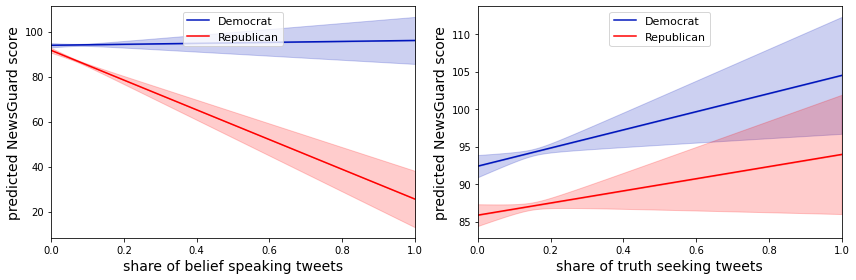

In [58]:
# similar to fig1 in this article https://www.pnas.org/doi/10.1073/pnas.1618923114
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, preds, xlabel in zip(axes.flatten(), 
        [(belief_pred_dem, belief_pred_rep), (truth_pred_dem, truth_pred_rep)],
        ["share of belief speaking tweets", "share of truth seeking tweets"]):
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("predicted NewsGuard score", fontsize=14)
    ax.set_xlim(0, 1)
    for pred, color, party in zip(preds, [demblue, repred], ["Democrat", "Republican"]):

        ax.plot(honesty_component_share, pred["mean"], color=color, label=party)
        ax.fill_between(honesty_component_share, 
                        pred["mean"],
                        pred["mean_ci_lower"], 
                        alpha=0.2, color=color)
        ax.fill_between(honesty_component_share, 
                        pred["mean"],
                        pred["mean_ci_upper"], 
                        alpha=0.2, color=color)
        ax.legend(loc=9, fontsize=11)
fig.tight_layout()
plt.savefig("../../plots/user_level_fishy_prediction.svg",
            bbox_inches="tight", facecolor="white")
plt.savefig("../../plots/user_level_fishy_prediction.png",
            bbox_inches="tight", facecolor="white")

## OLS regression cutoff 60

In [59]:
cols = ["fishy_share_60", "followers_count", "tweet_count", "belief_share", "truth_share", "party"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols]
mod = smf.ols(formula='fishy_share_60 ~ np.log(followers_count) + np.log(tweet_count) + belief_share + truth_share + party + party * belief_share + party * truth_share', data=subset)
#subset.rename(columns={"fishy_share_60":"misinfo_share"}).to_csv(join(src, "user_df_for_regression.csv.gzip"), compression="gzip", index=False)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         fishy_share_60   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     57.42
Date:                Wed, 18 May 2022   Prob (F-statistic):           2.60e-69
Time:                        14:09:18   Log-Likelihood:                 1845.5
No. Observations:                1017   AIC:                            -3675.
Df Residuals:                    1009   BIC:                            -3636.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0023      0.011      0.211      0.833      -0.019       0.023
party[T.Republican]                 -0.0047      0.009     -0.528      0.598      -0.022       0.013
np.log(followers_count)              0.0031      0.001      3.034      0.002       0.001       0.005
np.log(tweet_count)                 -0.0027      0.002     -1.721      0.086      -0.006       0.000
belief_share                         0.0202      0.059      0.345      0.730      -0.095       0.135
party[T.Republican]:belief_share     0.8920      0.091      9.793      0.000       0.713       1.071
truth_share                         -0.0620      0.048     -1.303      0.193      -0.155       0.031
party[T.Republican]:truth_share     -0.1520      0.064     -2.362      0.018      -0.278      -0.026
==============================================================================
Omnibus:                      752.448   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16572.036
Skew:                           3.168   Prob(JB):                         0.00
Kurtosis:                      21.733   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Variance inflation factor

In [22]:
cols = ["followers_count", "tweet_count", "belief_share", "truth_share", "party"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols].dropna().copy()
subset["party"] = subset["party"].replace({"Republican":1, "Democrat":0})
# add a constant which is needed according to this post: https://github.com/statsmodels/statsmodels/issues/2376
X = add_constant(subset)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const              15.104199
followers_count     1.086316
tweet_count         1.164896
belief_share        1.220094
truth_share         1.285305
party               1.033563
dtype: float64

## Prediction

In [23]:
subset = users[users["party"].isin(["Democrat", "Republican"])].copy()
mean_cols = ["followers_count", "tweet_count"]
for col in mean_cols:
    subset[col] = subset[col].mean()

honesty_component_share = np.arange(0, 1.01, 0.01)
N = len(honesty_component_share)
belief_pred_df_dem = pd.DataFrame({
    "belief_share":honesty_component_share,
    "party":["Democrat"] * N,
    "followers_count":[subset["followers_count"].mean()] * N,
    "tweet_count":[subset["tweet_count"].mean()] * N,
    "truth_share":[subset["truth_share"].mean()] * N
})
belief_pred_df_rep = pd.DataFrame({
    "belief_share":honesty_component_share,
    "party":["Republican"] * N,
    "followers_count":[subset["followers_count"].mean()] * N,
    "tweet_count":[subset["tweet_count"].mean()] * N,
    "truth_share":[subset["truth_share"].mean()] * N
})
truth_pred_df_dem = pd.DataFrame({
    "truth_share":honesty_component_share,
    "party":["Democrat"] * N,
    "followers_count":[subset["followers_count"].mean()] * N,
    "tweet_count":[subset["tweet_count"].mean()] * N,
    "belief_share":[subset["belief_share"].mean()] * N
})
truth_pred_df_rep = pd.DataFrame({
    "truth_share":honesty_component_share,
    "party":["Republican"] * N,
    "followers_count":[subset["followers_count"].mean()] * N,
    "tweet_count":[subset["tweet_count"].mean()] * N,
    "belief_share":[subset["belief_share"].mean()] * N
})

In [24]:
belief_pred_dem = res.get_prediction(belief_pred_df_dem)
belief_pred_rep = res.get_prediction(belief_pred_df_rep)
truth_pred_dem = res.get_prediction(truth_pred_df_dem)
truth_pred_rep = res.get_prediction(truth_pred_df_rep)

belief_pred_dem = belief_pred_dem.summary_frame(alpha=0.05)
belief_pred_dem["party"] = "Democrat"
belief_pred_dem["honesty_component"] = "belief"
belief_pred_rep = belief_pred_rep.summary_frame(alpha=0.05)
belief_pred_rep["party"] = "Republican"
belief_pred_rep["honesty_component"] = "belief"
truth_pred_dem = truth_pred_dem.summary_frame(alpha=0.05)
truth_pred_dem["party"] = "Democrat"
truth_pred_dem["honesty_component"] = "truth"
truth_pred_rep = truth_pred_rep.summary_frame(alpha=0.05)
truth_pred_rep["party"] = "Republican"
truth_pred_rep["honesty_component"] = "truth"

In [25]:
dst = "../../data/twitter"
fname = "OLS_predictions_fishy_60.csv"
predictions = pd.concat([
    belief_pred_dem,
    belief_pred_rep,
    truth_pred_dem,
    truth_pred_rep
]).reset_index(drop=True)
predictions.to_csv(join(dst, fname), index=False)

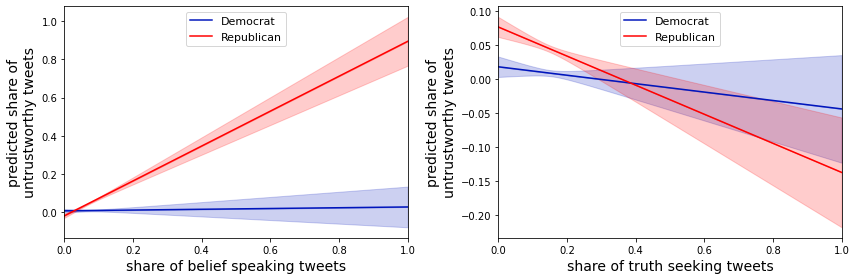

In [26]:
# similar to fig1 in this article https://www.pnas.org/doi/10.1073/pnas.1618923114
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, preds, xlabel in zip(axes.flatten(), 
        [(belief_pred_dem, belief_pred_rep), (truth_pred_dem, truth_pred_rep)],
        ["share of belief speaking tweets", "share of truth seeking tweets"]):
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("predicted share of\nuntrustworthy tweets", fontsize=14)
    ax.set_xlim(0, 1)
    for pred, color, party in zip(preds, [demblue, repred], ["Democrat", "Republican"]):

        ax.plot(honesty_component_share, pred["mean"], color=color, label=party)
        ax.fill_between(honesty_component_share, 
                        pred["mean"],
                        pred["mean_ci_lower"], 
                        alpha=0.2, color=color)
        ax.fill_between(honesty_component_share, 
                        pred["mean"],
                        pred["mean_ci_upper"], 
                        alpha=0.2, color=color)
        ax.legend(loc=9, fontsize=11)
fig.tight_layout()
plt.savefig("../../plots/user_level_fishy_prediction.svg",
            bbox_inches="tight", facecolor="white")
plt.savefig("../../plots/user_level_fishy_prediction.png",
            bbox_inches="tight", facecolor="white")

## OLS regression cutoff 40

In [40]:
cols = ["fishy_share_40", "followers_count", "tweet_count", "belief_share", "truth_share", "party"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols]
mod = smf.ols(formula='fishy_share_40 ~ np.log(followers_count) + np.log(tweet_count) + belief_share + truth_share + party + party * belief_share + party * truth_share', data=subset)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         fishy_share_40   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     45.77
Date:                Sun, 01 May 2022   Prob (F-statistic):           1.69e-56
Time:                        23:23:36   Log-Likelihood:                 4084.1
No. Observations:                1025   AIC:                            -8152.
Df Residuals:                    1017   BIC:                            -8113.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0007      0.001      0.622      0.534      -0.002       0.003
party[T.Republican]                 -0.0015      0.001     -1.487      0.137      -0.003       0.000
np.log(followers_count)           4.237e-05      0.000      0.361      0.718      -0.000       0.000
np.log(tweet_count)               1.279e-06      0.000      0.007      0.994      -0.000       0.000
belief_share                         0.0029      0.007      0.439      0.660      -0.010       0.016
party[T.Republican]:belief_share     0.0865      0.010      8.633      0.000       0.067       0.106
truth_share                         -0.0072      0.005     -1.385      0.166      -0.017       0.003
party[T.Republican]:truth_share     -0.0050      0.007     -0.715      0.475      -0.019       0.009
==============================================================================
Omnibus:                      836.346   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22021.951
Skew:                           3.606   Prob(JB):                         0.00
Kurtosis:                      24.532   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## OLS regression cutoff 20

In [41]:
cols = ["fishy_share_20", "followers_count", "tweet_count", "belief_share", "truth_share", "party"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols]
mod = smf.ols(formula='fishy_share_20 ~ np.log(followers_count) + np.log(tweet_count) + belief_share + truth_share + party + party * belief_share + party * truth_share', data=subset)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         fishy_share_20   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     36.21
Date:                Sun, 01 May 2022   Prob (F-statistic):           2.28e-45
Time:                        23:23:36   Log-Likelihood:                 4662.5
No. Observations:                1025   AIC:                            -9309.
Df Residuals:                    1017   BIC:                            -9270.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.0003      0.001     -0.443      0.658      -0.002       0.001
party[T.Republican]                 -0.0011      0.001     -1.830      0.068      -0.002    7.61e-05
np.log(followers_count)              0.0001   6.67e-05      2.211      0.027    1.66e-05       0.000
np.log(tweet_count)                 -0.0001    9.9e-05     -1.205      0.228      -0.000    7.49e-05
belief_share                        -0.0011      0.004     -0.291      0.771      -0.008       0.006
party[T.Republican]:belief_share     0.0451      0.006      7.909      0.000       0.034       0.056
truth_share                         -0.0012      0.003     -0.408      0.683      -0.007       0.005
party[T.Republican]:truth_share     -0.0013      0.004     -0.328      0.743      -0.009       0.006
==============================================================================
Omnibus:                     1060.829   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59103.413
Skew:                           4.934   Prob(JB):                         0.00
Kurtosis:                      38.868   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Independent list

## OLS regression share

In [185]:
cols = ["unreliable_share", "followers_count", "tweet_count", "belief_share", "truth_share", "party"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols]
mod = smf.ols(formula='unreliable_share ~ np.log(followers_count) + np.log(tweet_count) + belief_share + truth_share + party + party * belief_share + party * truth_share', data=subset)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       unreliable_share   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     86.17
Date:                Mon, 09 May 2022   Prob (F-statistic):           3.16e-98
Time:                        10:31:07   Log-Likelihood:                 1307.6
No. Observations:                1017   AIC:                            -2599.
Df Residuals:                    1009   BIC:                            -2560.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0183      0.018      1.017      0.309      -0.017       0.054
party[T.Republican]                  0.0357      0.015      2.329      0.020       0.006       0.066
np.log(followers_count)              0.0048      0.002      2.711      0.007       0.001       0.008
np.log(tweet_count)                 -0.0065      0.003     -2.450      0.014      -0.012      -0.001
belief_share                         0.0094      0.099      0.095      0.924      -0.185       0.204
party[T.Republican]:belief_share     1.2548      0.155      8.108      0.000       0.951       1.558
truth_share                         -0.0634      0.080     -0.791      0.429      -0.221       0.094
party[T.Republican]:truth_share     -0.2286      0.109     -2.096      0.036      -0.443      -0.015
==============================================================================
Omnibus:                      666.441   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12930.022
Skew:                           2.690   Prob(JB):                         0.00
Kurtosis:                      19.619   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## OLS regression accuracy score

In [109]:
cols = ["accuracy_mean", "followers_count", "tweet_count", "belief_share", "truth_share", "party"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols]
mod = smf.ols(formula='accuracy_mean ~ np.log(followers_count) + np.log(tweet_count) + belief_share + truth_share + party + party * belief_share + party * truth_share', data=subset)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          accuracy_mean   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     67.17
Date:                Fri, 13 May 2022   Prob (F-statistic):           1.54e-79
Time:                        12:35:07   Log-Likelihood:                -265.92
No. Observations:                1017   AIC:                             547.8
Df Residuals:                    1009   BIC:                             587.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            4.2413      0.085     50.091      0.000       4.075       4.407
party[T.Republican]                 -0.1185      0.072     -1.647      0.100      -0.260       0.023
np.log(followers_count)             -0.0215      0.008     -2.608      0.009      -0.038      -0.005
np.log(tweet_count)                  0.0153      0.013      1.221      0.222      -0.009       0.040
belief_share                        -1.3171      0.466     -2.827      0.005      -2.231      -0.403
party[T.Republican]:belief_share    -4.6448      0.727     -6.389      0.000      -6.072      -3.218
truth_share                          0.2420      0.377      0.643      0.521      -0.497       0.981
party[T.Republican]:truth_share      0.5608      0.512      1.094      0.274      -0.445       1.566
==============================================================================
Omnibus:                      106.194   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.362
Skew:                          -0.411   Prob(JB):                     1.76e-95
Kurtosis:                       6.102   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
tab = make_regression_table(res, subset, "accuracy_mean", name_map)
dst = "../../tables"
fname = "OLS_table_accuracy.txt"
with open(join(dst, fname), "w") as f:
    f.write(tab)

## OLS regression transparency score

In [111]:
cols = ["transparency_mean", "followers_count", "tweet_count", "belief_share", "truth_share", "party"]
subset = users[users["party"].isin(["Democrat", "Republican"])][cols]
mod = smf.ols(formula='transparency_mean ~ np.log(followers_count) + np.log(tweet_count) + belief_share + truth_share + party + party * belief_share + party * truth_share', data=subset)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      transparency_mean   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     117.1
Date:                Fri, 13 May 2022   Prob (F-statistic):          1.23e-125
Time:                        12:35:14   Log-Likelihood:                 333.55
No. Observations:                1017   AIC:                            -651.1
Df Residuals:                    1009   BIC:                            -611.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            2.8187      0.047     60.021      0.000       2.727       2.911
party[T.Republican]                 -0.1107      0.040     -2.775      0.006      -0.189      -0.032
np.log(followers_count)             -0.0116      0.005     -2.536      0.011      -0.021      -0.003
np.log(tweet_count)                  0.0209      0.007      3.013      0.003       0.007       0.035
belief_share                        -0.5397      0.258     -2.089      0.037      -1.047      -0.033
party[T.Republican]:belief_share    -2.9065      0.403     -7.208      0.000      -3.698      -2.115
truth_share                          0.3227      0.209      1.545      0.123      -0.087       0.733
party[T.Republican]:truth_share      0.2269      0.284      0.798      0.425      -0.331       0.785
==============================================================================
Omnibus:                      219.300   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              885.984
Skew:                          -0.968   Prob(JB):                    4.08e-193
Kurtosis:                       7.143   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [112]:
tab = make_regression_table(res, subset, "transparency_mean", name_map)
dst = "../../tables"
fname = "OLS_table_transparency.txt"
with open(join(dst, fname), "w") as f:
    f.write(tab)

# Article texts

## OLS regression Score

In [131]:
src = "../../data/twitter"
fname = "full_links_with_text_and_honesty.csv"
cols = ["belief", "truth", "other_words", "wc", "belief_prop", "truth_prop",
        "Score", "url", "party"]
texts = pd.read_csv(join(src, fname), usecols=cols)
texts = texts.rename(columns={"Score":"NG_score"})

In [132]:
len(texts)

162508

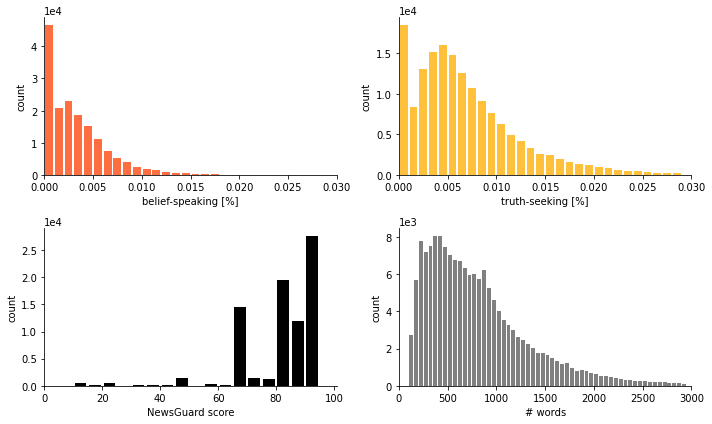

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0][0].hist(texts["belief_prop"], bins=np.arange(0, 0.03, 0.001), 
                rwidth=0.8, color="#ff6e40")
axes[0][0].set_xlim(0, 0.03)
axes[0][0].set_xlabel("belief-speaking [%]")

axes[0][1].hist(texts["truth_prop"], bins=np.arange(0, 0.03, 0.001), 
                rwidth=0.8, color="#ffc13b")
axes[0][1].set_xlim(0, 0.03)
axes[0][1].set_xlabel("truth-seeking [%]")

axes[1][0].hist(texts["NG_score"], bins=np.arange(0, 100, 5),
                rwidth=0.8, color='k')
axes[1][0].set_xlim(0, 101)
axes[1][0].set_xlabel("NewsGuard score")

axes[1][1].hist(texts["wc"], bins=np.arange(0, 3000, 50),
                rwidth=0.8, color="grey")
axes[1][1].set_xlim(0, 3001)
axes[1][1].set_xlabel("# words")
for ax in axes.flatten():
    ax.set_ylabel("count")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
fig.tight_layout()

In [126]:
fname = "article_scores_with_parties.csv.gzip"
cols = ["NG_score", "belief_prop", "truth_prop", "party"]
texts[cols].to_csv(join(src, fname), index=False, compression="gzip")

In [127]:
mod = smf.ols(formula='NG_score ~ belief_prop + truth_prop + party + party * belief_prop + party * truth_prop', data=texts)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               NG_score   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     4847.
Date:                Wed, 18 May 2022   Prob (F-statistic):               0.00
Time:                        19:10:56   Log-Likelihood:            -6.2796e+05
No. Observations:              160750   AIC:                         1.256e+06
Df Residuals:                  160744   BIC:                         1.256e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          94.7729      0.068   1396.422      0.000      94.640      94.906
party[T.Republican]                -9.1938      0.108    -84.746      0.000      -9.406      -8.981
belief_prop                       -42.5632     11.542     -3.688      0.000     -65.186     -19.940
party[T.Republican]:belief_prop   -19.1074     17.684     -1.080      0.280     -53.768      15.553
truth_prop                         19.3650      6.108      3.170      0.002       7.393      31.337
party[T.Republican]:truth_prop    -46.6972      9.855     -4.739      0.000     -66.012     -27.383
==============================================================================
Omnibus:                    64018.333   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           370739.046
Skew:                          -1.831   Prob(JB):                         0.00
Kurtosis:                       9.476   Cond. No.                         710.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
name_map = {
    "Intercept":"Intercept",
    "party[T.Republican]":"Republican",
    "belief_prop":"belief-speaking",
    "party[T.Republican]:belief_prop":"Rep. $\\times$ belief-speaking",
    "truth_prop":"truth-seeking",
    "party[T.Republican]:truth_prop":"Rep. $\\times$ truth-seeking"
}

tab = make_regression_table(res, texts, "NG_score", name_map)
dst = "../../tables"
fname = "OLS_table_article_NG_score.txt"
with open(join(dst, fname), "w") as f:
    f.write(tab)

## Prediction

In [118]:
honesty_component_share = np.arange(-0.01, 0.21, 0.001)
N = len(honesty_component_share)
belief_pred_df_dem = pd.DataFrame({
    "belief_prop":honesty_component_share,
    "party":["Democrat"] * N,
    "truth_prop":[texts["truth_prop"].mean()] * N
})
belief_pred_df_rep = pd.DataFrame({
    "belief_prop":honesty_component_share,
    "party":["Republican"] * N,
    "truth_prop":[texts["truth_prop"].mean()] * N
})
truth_pred_df_dem = pd.DataFrame({
    "truth_prop":honesty_component_share,
    "party":["Democrat"] * N,
    "belief_prop":[texts["belief_prop"].mean()] * N
})
truth_pred_df_rep = pd.DataFrame({
    "truth_prop":honesty_component_share,
    "party":["Republican"] * N,
    "belief_prop":[texts["belief_prop"].mean()] * N
})

In [119]:
belief_pred_dem = res.get_prediction(belief_pred_df_dem)
belief_pred_rep = res.get_prediction(belief_pred_df_rep)
truth_pred_dem = res.get_prediction(truth_pred_df_dem)
truth_pred_rep = res.get_prediction(truth_pred_df_rep)

belief_pred_dem = belief_pred_dem.summary_frame(alpha=0.05)
belief_pred_dem["party"] = "Democrat"
belief_pred_dem["honesty_component"] = "belief"
belief_pred_rep = belief_pred_rep.summary_frame(alpha=0.05)
belief_pred_rep["party"] = "Republican"
belief_pred_rep["honesty_component"] = "belief"
truth_pred_dem = truth_pred_dem.summary_frame(alpha=0.05)
truth_pred_dem["party"] = "Democrat"
truth_pred_dem["honesty_component"] = "truth"
truth_pred_rep = truth_pred_rep.summary_frame(alpha=0.05)
truth_pred_rep["party"] = "Republican"
truth_pred_rep["honesty_component"] = "truth"

In [120]:
dst = "../../data/twitter"
fname = "OLS_predictions_articles.csv"
predictions = pd.concat([
    belief_pred_dem,
    belief_pred_rep,
    truth_pred_dem,
    truth_pred_rep
]).reset_index(drop=True)
predictions.to_csv(join(dst, fname), index=False)

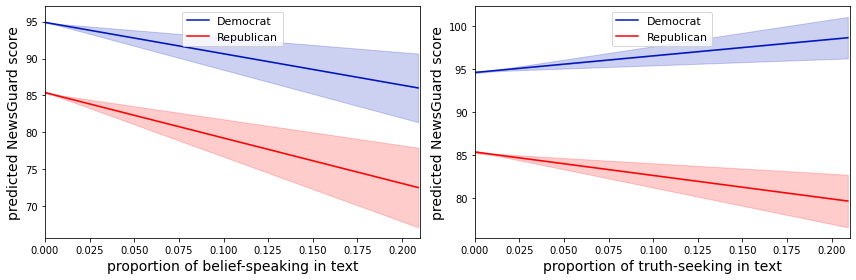

In [121]:
# similar to fig1 in this article https://www.pnas.org/doi/10.1073/pnas.1618923114
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, preds, xlabel in zip(axes.flatten(), 
        [(belief_pred_dem, belief_pred_rep), (truth_pred_dem, truth_pred_rep)],
        ["proportion of belief-speaking in text", "proportion of truth-seeking in text"]):
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("predicted NewsGuard score", fontsize=14)
    ax.set_xlim(0, 0.21)
    for pred, color, party in zip(preds, [demblue, repred], ["Democrat", "Republican"]):

        ax.plot(honesty_component_share, pred["mean"], color=color, label=party)
        ax.fill_between(honesty_component_share, 
                        pred["mean"],
                        pred["mean_ci_lower"], 
                        alpha=0.2, color=color)
        ax.fill_between(honesty_component_share, 
                        pred["mean"],
                        pred["mean_ci_upper"], 
                        alpha=0.2, color=color)
        ax.legend(loc=9, fontsize=11)
fig.tight_layout()

# Retweets & likes

In [1]:
# formulas
formula_retweets = "np.log(retweet_count + 1) ~ newsguard_score * party + np.log(followers_count) + month_since_start"
formula_likes = "np.log(like_count + 1) ~ newsguard_score * party + np.log(followers_count) + month_since_start"

## US

In [4]:
# load user account statistics
src = "../../data/twitter"
fname = "US_politician_twitter_account_stats_2010-11-06_to_2022-03-16.csv"
users = pd.read_csv(join(src, fname))

# load tweets
fname = "US_politician_tweets_2010-11-06_to_2022-03-16.csv.gzip"
tweets = pd.read_csv(join(src, fname), compression="gzip", parse_dates=["created_at"])

In [5]:
# remove tweets without URLs
tweets = tweets[tweets["has_url"] == True].copy()

# create an ordinal variable indicating month since data collection start
tweets = tweets.reset_index()
tweets["year"] = pd.to_datetime("2022-03-15")
diff = tweets['year'].dt.to_period('M').astype(int) - \
    tweets['created_at'].dt.to_period('M').astype(int)
tweets["month_since_start"] = diff.max() - diff
tweets = tweets.drop(columns=["year"])

# add information about the number of followers of the posting account at the
# time of data collection
tweets = pd.merge(tweets, users[["author_id", "followers_count"]], 
                  how="left", left_on="author_id", right_on="author_id")

/tmp/ipykernel_342792/161691216.py:7: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  diff = tweets['year'].dt.to_period('M').astype(int) - \
/home/jana/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/tmp/ipykernel_342792/161691216.py:8: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tweets['created_at'].dt.to_period('M').astype(int)


In [6]:
tweets["party"] = tweets["party"].replace({"Republican":"1_Republican", "Democrat":"2_Democrat"})
tweets = tweets.rename(columns={"Score":"newsguard_score"})

In [202]:
# (tweet | user)  intercept & slope für jeden user äquivalent zu (1 + tweet | user) = (tweet | user)
# 1 | user nur intercept für jeden user
# (1 | user | party)
# "treatment coding" (Republican: 0, Democrat: 1)
# "deviation coding": zum mean der Parteien vergleichen
# nested: user in party

In [7]:
cols = ["retweet_count", "like_count", "newsguard_score", "month_since_start", "followers_count", "party", "author_id"]
subset = tweets[cols][tweets["party"].isin(["1_Republican", "2_Democrat"])].dropna()
mod_retweet = smf.mixedlm(formula=formula_retweets, data=subset, groups=subset["author_id"])
mod_like = smf.mixedlm(formula=formula_likes, data=subset, groups=subset["author_id"])
subset[cols].to_csv(join(src, "US_tweet_df_for_regression.csv"), index=False)
res_retweet_US = mod_retweet.fit()
res_like_US = mod_like.fit()

In [8]:
res_retweet_US.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                MixedLM   Dependent Variable:   np.log(retweet_count + 1)
No. Observations:     299739    Method:               REML                     
No. Groups:           1018      Scale:                1.2007                   
Min. group size:      1         Log-Likelihood:       -454901.7765             
Max. group size:      2159      Converged:            Yes                      
Mean group size:      294.4                                                    
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                           -3.831    0.123 -31.252 0.000 -4.072 -3.591
party[T.2_Democrat]                 -0.528    0.055  -9.676 0.000 -0.636 -0.421
newsguard_score                     -0.009    0.000 -44.603 0.000 -0.010 -0.009
newsguard_score:party[T.2_Democrat]  0.008    0.000  19.358 0.000  0.007  0.008
np.log(followers_count)              0.576    0.012  48.642 0.000  0.553  0.599
month_since_start                    0.008    0.000  68.905 0.000  0.008  0.008
Group Var                            0.408    0.017                            
===============================================================================

"""

In [9]:
res_like_US.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                 MixedLM    Dependent Variable:    np.log(like_count + 1)
No. Observations:      299739     Method:                REML                  
No. Groups:            1018       Scale:                 1.6873                
Min. group size:       1          Log-Likelihood:        -505874.2463          
Max. group size:       2159       Converged:             Yes                   
Mean group size:       294.4                                                   
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                           -5.849    0.143 -40.981 0.000 -6.128 -5.569
party[T.2_Democrat]                  0.027    0.064   0.423 0.672 -0.098  0.153
newsguard_score                     -0.001    0.000  -4.832 0.000 -0.002 -0.001
newsguard_score:party[T.2_Democrat]  0.003    0.000   6.008 0.000  0.002  0.004
np.log(followers_count)              0.614    0.014  44.529 0.000  0.587  0.641
month_since_start                    0.021    0.000 146.646 0.000  0.020  0.021
Group Var                            0.551    0.019                            
===============================================================================

"""

In [10]:
tweets["party"] = tweets["party"].replace({"1_Republican":"2_Republican", "2_Democrat":"1_Democrat"})
subset = tweets[cols][tweets["party"].isin(["2_Republican", "1_Democrat"])].dropna()
mod_retweet = smf.mixedlm(formula=formula_retweets, data=subset, groups=subset["author_id"])
mod_like = smf.mixedlm(formula=formula_likes, data=subset, groups=subset["author_id"])
res_retweet_US = mod_retweet.fit()
res_like_US = mod_like.fit()

In [11]:
res_retweet_US.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                MixedLM    Dependent Variable:    np.log(retweet_count + 1)
No. Observations:     299739     Method:                REML                     
No. Groups:           1018       Scale:                 1.2007                   
Min. group size:      1          Log-Likelihood:        -454901.7765             
Max. group size:      2159       Converged:             Yes                      
Mean group size:      294.4                                                      
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                             -4.360    0.131 -33.229 0.000 -4.617 -4.103
party[T.2_Republican]                  0.528    0.055   9.676 0.000  0.421  0.636
newsguard_score                       -0.002    0.000  -4.831 0.000 -0.002 -0.001
newsguard_score:party[T.2_Republican] -0.008    0.000 -19.358 0.000 -0.008 -0.007
np.log(followers_count)                0.576    0.012  48.642 0.000  0.553  0.599
month_since_start                      0.008    0.000  68.905 0.000  0.008  0.008
Group Var                              0.408    0.017                            
=================================================================================

"""

In [12]:
res_like_US.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                 MixedLM     Dependent Variable:     np.log(like_count + 1)
No. Observations:      299739      Method:                 REML                  
No. Groups:            1018        Scale:                  1.6873                
Min. group size:       1           Log-Likelihood:         -505874.2463          
Max. group size:       2159        Converged:              Yes                   
Mean group size:       294.4                                                     
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                             -5.821    0.153 -38.093 0.000 -6.121 -5.522
party[T.2_Republican]                 -0.027    0.064  -0.423 0.672 -0.153  0.098
newsguard_score                        0.002    0.000   4.077 0.000  0.001  0.002
newsguard_score:party[T.2_Republican] -0.003    0.000  -6.008 0.000 -0.004 -0.002
np.log(followers_count)                0.614    0.014  44.529 0.000  0.587  0.641
month_since_start                      0.021    0.000 146.646 0.000  0.020  0.021
Group Var                              0.551    0.019                            
=================================================================================

"""

**Republican**: 
* for every point decrease in `newsguard_score`, retweets go up by 0.9%.  
* for every point decrease in `newsguard_score`, likes go up by 0.1%.  

**Democrat**: 
* for every point decrease in `newsguard_score`, retweets go up by 0.2%.
* for every point decrease in `newsguard_score`, likes go down by 0.2%.

## UK

In [17]:
# load user account statistics
src = "../../../untrustworthy/data"
fname = "PNAS_UK_politician_twitter_account_stats_2016-01-01_to_2022-03-16.csv"
users = pd.read_csv(join(src, fname))

# load tweets
fname = "PNAS_UK_politician_tweets_2016-01-01_to_2022-03-16.csv.gzip"
tweets = pd.read_csv(join(src, fname), compression="gzip", parse_dates=["created_at"])

In [18]:
# remove tweets without URLs
tweets = tweets[tweets["has_url"] == True].copy()

# create an ordinal variable indicating month since data collection start
tweets = tweets.reset_index()
tweets["year"] = pd.to_datetime("2022-03-15")
diff = tweets['year'].dt.to_period('M').astype(int) - \
    tweets['created_at'].dt.to_period('M').astype(int)
tweets["month_since_start"] = diff.max() - diff
tweets = tweets.drop(columns=["year"])

# add information about the number of followers of the posting account at the
# time of data collection
tweets = pd.merge(tweets, users[["author_id", "followers_count"]], 
                  how="left", left_on="author_id", right_on="author_id")

/tmp/ipykernel_342792/161691216.py:7: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  diff = tweets['year'].dt.to_period('M').astype(int) - \
/home/jana/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/tmp/ipykernel_342792/161691216.py:8: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tweets['created_at'].dt.to_period('M').astype(int)


In [19]:
tweets["party"] = tweets["party"].replace({
    "Conservative":"1_Conservative",
    "Labour":"2_Labour",
    "Social Democratic & Labour Party":"2_Labour",
    "Labour Co-op":"2_Labour",
    "Liberal Democrat":"3_Liberal Democrat",
    "Democratic Unionist Party":"4_Democratic Unionist Party",
    "Scottish National Party":"5_Scottish National Party",
    "Speaker":"6_other & independent",
    "Independent":"6_other & independent",
    "Alliance":"6_other & independent",
    "Green Party":"6_other & independent",
})
tweets = tweets.rename(columns={"Score":"newsguard_score"})

In [20]:
cols = ["retweet_count", "like_count", "newsguard_score", "month_since_start", "followers_count", "party", "author_id"]
parties = ["1_Conservative", "2_Labour"]
subset = tweets[cols][tweets["party"].isin(parties)].dropna()
subset[cols].to_csv(join(src, "UK_tweet_df_for_regression.csv"), index=False)
mod_retweet = smf.mixedlm(formula=formula_retweets, data=subset, groups=subset["author_id"])
mod_like = smf.mixedlm(formula=formula_likes, data=subset, groups=subset["author_id"])
res_retweet_UK = mod_retweet.fit()
res_like_UK = mod_like.fit()

In [21]:
res_retweet_UK.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:              MixedLM   Dependent Variable:   np.log(retweet_count + 1)
No. Observations:   55540     Method:               REML                     
No. Groups:         604       Scale:                1.5218                   
Min. group size:    1         Log-Likelihood:       -91329.6367              
Max. group size:    1079      Converged:            Yes                      
Mean group size:    92.0                                                     
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                         -5.015    0.265 -18.915 0.000 -5.535 -4.495
party[T.2_Labour]                 -1.021    0.116  -8.777 0.000 -1.249 -0.793
newsguard_score                   -0.010    0.001 -13.154 0.000 -0.011 -0.008
newsguard_score:party[T.2_Labour]  0.012    0.001  10.687 0.000  0.010  0.014
np.log(followers_count)            0.796    0.026  30.779 0.000  0.745  0.847
month_since_start                 -0.002    0.000  -5.255 0.000 -0.003 -0.002
Group Var                          0.434    0.022                            
=============================================================================

"""

In [22]:
res_like_UK.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:               MixedLM    Dependent Variable:    np.log(like_count + 1)
No. Observations:    55540      Method:                REML                  
No. Groups:          604        Scale:                 1.6194                
Min. group size:     1          Log-Likelihood:        -93108.5400           
Max. group size:     1079       Converged:             Yes                   
Mean group size:     92.0                                                    
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                         -6.168    0.298 -20.683 0.000 -6.753 -5.584
party[T.2_Labour]                 -1.221    0.123  -9.923 0.000 -1.462 -0.980
newsguard_score                   -0.009    0.001 -12.285 0.000 -0.011 -0.008
newsguard_score:party[T.2_Labour]  0.011    0.001   9.852 0.000  0.009  0.013
np.log(followers_count)            0.924    0.029  31.565 0.000  0.866  0.981
month_since_start                  0.013    0.000  27.245 0.000  0.012  0.014
Group Var                          0.564    0.028                            
=============================================================================

"""

In [26]:
subset["party"] = subset["party"].replace({"1_Conservative":"2_Conservative", "2_Labour":"1_Labour"})
mod_retweet = smf.mixedlm(formula=formula_retweets, data=subset, groups=subset["author_id"])
mod_like = smf.mixedlm(formula=formula_likes, data=subset, groups=subset["author_id"])
res_retweet_UK = mod_retweet.fit()
res_like_UK = mod_like.fit()

In [27]:
res_retweet_UK.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                MixedLM     Dependent Variable:     np.log(retweet_count + 1)
No. Observations:     55540       Method:                 REML                     
No. Groups:           604         Scale:                  1.5218                   
Min. group size:      1           Log-Likelihood:         -91329.6367              
Max. group size:      1079        Converged:              Yes                      
Mean group size:      92.0                                                         
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                               -6.036    0.279 -21.650 0.000 -6.582 -5.489
party[T.2_Conservative]                  1.021    0.116   8.777 0.000  0.793  1.249
newsguard_score                          0.002    0.001   2.432 0.015  0.000  0.004
newsguard_score:party[T.2_Conservative] -0.012    0.001 -10.687 0.000 -0.014 -0.010
np.log(followers_count)                  0.796    0.026  30.779 0.000  0.745  0.847
month_since_start                       -0.002    0.000  -5.255 0.000 -0.003 -0.002
Group Var                                0.434    0.022                            
===================================================================================

"""

In [28]:
res_like_UK.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                 MixedLM      Dependent Variable:      np.log(like_count + 1)
No. Observations:      55540        Method:                  REML                  
No. Groups:            604          Scale:                   1.6194                
Min. group size:       1            Log-Likelihood:          -93108.5400           
Max. group size:       1079         Converged:               Yes                   
Mean group size:       92.0                                                        
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                               -7.389    0.313 -23.575 0.000 -8.003 -6.775
party[T.2_Conservative]                  1.221    0.123   9.923 0.000  0.980  1.462
newsguard_score                          0.002    0.001   2.095 0.036  0.000  0.003
newsguard_score:party[T.2_Conservative] -0.011    0.001  -9.852 0.000 -0.013 -0.009
np.log(followers_count)                  0.924    0.029  31.565 0.000  0.866  0.981
month_since_start                        0.013    0.000  27.245 0.000  0.012  0.014
Group Var                                0.564    0.028                            
===================================================================================

"""

**Conservative**: 
* for every point decrease in `newsguard_score`, retweets go up by 1.0%.  
* for every point decrease in `newsguard_score`, likes go up by 0.9%.  

**Labour**: 
* for every point decrease in `newsguard_score`, retweets go down by 0.2%.
* for every point decrease in `newsguard_score`, likes go down by 0.2%.

## DE

In [38]:
# load user account statistics
src = "../../../untrustworthy/data"
fname = "PNAS_DE_politician_twitter_account_stats_2016-01-01_to_2022-03-16.csv"
users = pd.read_csv(join(src, fname))

# load tweets
fname = "PNAS_DE_politician_tweets_2016-01-01_to_2022-03-16.csv.gzip"
tweets = pd.read_csv(join(src, fname), compression="gzip", parse_dates=["created_at"])

In [39]:
# remove tweets without URLs
tweets = tweets[tweets["has_url"] == True].copy()

# create an ordinal variable indicating month since data collection start
tweets = tweets.reset_index()
tweets["year"] = pd.to_datetime("2022-03-15")
diff = tweets['year'].dt.to_period('M').astype(int) - \
    tweets['created_at'].dt.to_period('M').astype(int)
tweets["month_since_start"] = diff.max() - diff
tweets = tweets.drop(columns=["year"])

# add information about the number of followers of the posting account at the
# time of data collection
tweets = pd.merge(tweets, users[["author_id", "followers_count"]], 
                  how="left", left_on="author_id", right_on="author_id")

/tmp/ipykernel_342792/161691216.py:7: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  diff = tweets['year'].dt.to_period('M').astype(int) - \
/home/jana/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/tmp/ipykernel_342792/161691216.py:8: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tweets['created_at'].dt.to_period('M').astype(int)


In [40]:
tweets["party"] = tweets["party"].replace({
    "CDU":"1_CDU/CSU",
    "CSU":"1_CDU/CSU",
    "CDU/CSU":"1_CDU/CSU",
    "SPD":"2_SPD",
    "FDP":"3_FDP",
    "Alliance 90/The Greens":"4_Alliance 90/The Greens",
    "The Left Party":"5_The Left Party",
    "AfD":"6_AFD",
    "AFD":"6_AFD"
})
tweets = tweets.rename(columns={"Score":"newsguard_score"})

In [41]:
cols = ["retweet_count", "like_count", "newsguard_score", "month_since_start", "followers_count", "party", "author_id"]
parties = ['1_CDU/CSU', '2_SPD']
subset = tweets[cols][tweets["party"].isin(parties)].dropna()
subset[cols].to_csv(join(src, "DE_tweet_df_for_regression.csv"), index=False)
mod_retweet = smf.mixedlm(formula=formula_retweets, data=subset, groups=subset["author_id"])
mod_like = smf.mixedlm(formula=formula_likes, data=subset, groups=subset["author_id"])
res_retweet_DE = mod_retweet.fit()
res_like_DE = mod_like.fit()

In [42]:
res_retweet_DE.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:             MixedLM  Dependent Variable:  np.log(retweet_count + 1)
No. Observations:  19028    Method:              REML                     
No. Groups:        333      Scale:               0.8333                   
Min. group size:   1        Log-Likelihood:      -25612.3821              
Max. group size:   840      Converged:           Yes                      
Mean group size:   57.1                                                   
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -1.994    0.191 -10.440 0.000 -2.369 -1.620
party[T.2_SPD]                 -0.783    0.191  -4.099 0.000 -1.158 -0.409
newsguard_score                -0.010    0.001  -8.884 0.000 -0.012 -0.008
newsguard_score:party[T.2_SPD]  0.007    0.002   3.864 0.000  0.004  0.011
np.log(followers_count)         0.414    0.019  22.215 0.000  0.378  0.451
month_since_start               0.011    0.000  22.437 0.000  0.010  0.012
Group Var                       0.191    0.020                            
==========================================================================

"""

In [43]:
res_like_DE.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:              MixedLM   Dependent Variable:   np.log(like_count + 1)
No. Observations:   19028     Method:               REML                  
No. Groups:         333       Scale:                1.1502                
Min. group size:    1         Log-Likelihood:       -28722.6207           
Max. group size:    840       Converged:            Yes                   
Mean group size:    57.1                                                  
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.970    0.248 -11.963 0.000 -3.456 -2.483
party[T.2_SPD]                 -0.928    0.228  -4.069 0.000 -1.375 -0.481
newsguard_score                -0.012    0.001  -9.262 0.000 -0.015 -0.010
newsguard_score:party[T.2_SPD]  0.010    0.002   4.209 0.000  0.005  0.014
np.log(followers_count)         0.592    0.025  23.434 0.000  0.543  0.642
month_since_start               0.027    0.001  46.542 0.000  0.025  0.028
Group Var                       0.375    0.034                            
==========================================================================

"""

In [44]:
subset["party"] = subset["party"].replace({"1_CDU/CSU":"2_CDU/CSU", "2_SPD":"1_SPD"})
mod_retweet = smf.mixedlm(formula=formula_retweets, data=subset, groups=subset["author_id"])
mod_like = smf.mixedlm(formula=formula_likes, data=subset, groups=subset["author_id"])
res_retweet_DE = mod_retweet.fit()
res_like_DE = mod_like.fit()

In [45]:
res_retweet_DE.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:               MixedLM   Dependent Variable:   np.log(retweet_count + 1)
No. Observations:    19028     Method:               REML                     
No. Groups:          333       Scale:                0.8333                   
Min. group size:     1         Log-Likelihood:       -25612.3821              
Max. group size:     840       Converged:            Yes                      
Mean group size:     57.1                                                     
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          -2.778    0.221 -12.585 0.000 -3.210 -2.345
party[T.2_CDU/CSU]                  0.783    0.191   4.099 0.000  0.409  1.158
newsguard_score                    -0.003    0.002  -1.672 0.095 -0.006  0.000
newsguard_score:party[T.2_CDU/CSU] -0.007    0.002  -3.864 0.000 -0.011 -0.004
np.log(followers_count)             0.414    0.019  22.215 0.000  0.378  0.451
month_since_start                   0.011    0.000  22.437 0.000  0.010  0.012
Group Var                           0.191    0.020                            
==============================================================================

"""

In [46]:
res_like_DE.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                MixedLM    Dependent Variable:    np.log(like_count + 1)
No. Observations:     19028      Method:                REML                  
No. Groups:           333        Scale:                 1.1502                
Min. group size:      1          Log-Likelihood:        -28722.6207           
Max. group size:      840        Converged:             Yes                   
Mean group size:      57.1                                                    
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          -3.898    0.281 -13.849 0.000 -4.449 -3.346
party[T.2_CDU/CSU]                  0.928    0.228   4.069 0.000  0.481  1.375
newsguard_score                    -0.003    0.002  -1.518 0.129 -0.006  0.001
newsguard_score:party[T.2_CDU/CSU] -0.010    0.002  -4.209 0.000 -0.014 -0.005
np.log(followers_count)             0.592    0.025  23.434 0.000  0.543  0.642
month_since_start                   0.027    0.001  46.542 0.000  0.025  0.028
Group Var                           0.375    0.034                            
==============================================================================

"""

**CDU/CSU**: 
* for every point decrease in `newsguard_score`, retweets go up by 1.0%.  
* for every point decrease in `newsguard_score`, likes go up by 1.2%.  

**SPD**: 
* for every point decrease in `newsguard_score`, retweets go up by 0.3% [not significant].
* for every point decrease in `newsguard_score`, likes go up by 0.3% [not significant].